# Statistical Learning 

## Class Competition: Netflix Data

## Predictions

 - Week 1: we had an error in script
 - Week 2: we used 2.5 for null values, prediction using Lasso + GBM
 - Week 3: $$user\_avg \cdot user\_prop + movie\_avg \cdot (1-user\_prop) - penalty$$ for nulls.
 - Week 4: Add some more features. 0.7 * lasso + 0.3 * gbm (+ bug fix from prior week)...
 - Week 5: Ensemble model.
 - Week 6: Added some new features and Truncated SVD
 - Week 7: New features: prop_i, xxx_is_rate. Predict using Lasso only.
 - Week 8: GBM + Lasso, with some new features, scaling outside lasso, and indicator for missing ratings.
 - Week 9: new features: min/max ratings. Fill nulls using Lasso. model - GBM + Lasso (mean)
 - Week 10: Fill nulls using Lasso. model - GBM + Lasso + ridge (mean). Test RMSE = .7591
 - Week 11: make sure that all ratings in [1,5] after imputation + do not scale `xx_is_rate` features + use cv in order to choose best coefs for predictions (Lasso + GBM + Ridge)
 
# Navigation

1. [Get Data](#Get-Data)
1. [New Features](#New-Features)
1. [Fix Nulls](#Fix-Nulls)
1. [Netflix Class](#Netflix-Class)
1. [Modeling & Tests](#Modeling-&-Tests)
    - [CV Results](#CV-Results)
1. [Prediction](#Prediction)
1. [Data Exploration & Visualisation](#Data-Exploration-&-Visualisation)

In [200]:
from IPython.display import display, clear_output

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RidgeCV
from sklearn.cluster import KMeans
 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from scipy.spatial.distance import cosine

# from sklearn.preprocessing import Imputer

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from numpy.linalg import svd

# class imputation
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import Imputer
from sklearn.utils.validation import check_array, check_is_fitted, check_X_y

# from surprise import evaluate, print_perf, Dataset
# from surprise import SVD, SVDpp

import time

from ggplot import *
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Get Data

[Top](#Navigation)

In [2]:
# read data
X_train = pd.read_csv("Data/X_train.csv")
X_train_dates = pd.read_csv("Data/X_train_dates.csv")
y_train_dates = pd.read_csv("Data/y_train_dates.csv")
y_train_full = pd.read_csv("Data/y_train.csv")

X_test = pd.read_csv("Data/X_test.csv")
X_test_dates = pd.read_csv("Data/X_test_dates.csv")
y_test_dates = pd.read_csv("Data/y_test_dates.csv")

titles = pd.read_csv("Data/titles.csv")

# col names
titles.columns = ['date', 'title']
X_train.columns = titles.title
X_train_dates.columns = titles.title
X_test.columns = titles.title
X_test_dates.columns = titles.title

X_train.head()

title,Independence Day,The Patriot,The Day After Tomorrow,Pirates of the Caribbean: The Curse of the Black Pearl,Pretty Woman,Forrest Gump,The Green Mile,Con Air,Twister,Sweet Home Alabama,...,Somethings Gotta Give,Raiders of the Lost Ark,Anger Management,Sideways,Kill Bill: Vol. 2,American Pie,The Fast and the Furious,The School of Rock,Napoleon Dynamite,The Notebook
0,4,4,3,5,4,5,4,4,5,4,...,5,5,4,4,5,5,5,5,0,4
1,4,5,3,3,4,3,4,4,3,2,...,4,4,3,2,3,3,0,3,3,5
2,5,5,5,5,4,5,4,3,4,5,...,5,4,4,0,0,5,5,0,0,0
3,5,5,5,5,4,5,5,3,4,5,...,4,5,5,4,4,2,4,2,2,0
4,5,5,5,5,5,5,5,5,5,5,...,3,0,3,0,2,4,5,4,0,5


## New Features

[Top](#Navigatin)

Function that generates all new features.

In [3]:
# similar movies
corr_tmp = X_train.copy()
corr_tmp['response'] = y_train_full.V1
corr = corr_tmp.corr()
similar_movies = corr.response[(corr.response > .3) & (corr.response < 1)].index.tolist()
similar_movies

['Pretty Woman',
 'Twister',
 'Sweet Home Alabama',
 'What Women Want',
 'Sister Act',
 'Two Weeks Notice',
 'The Wedding Planner',
 'Maid in Manhattan']

In [4]:
# dissimilar movies
dissimilar_movies = corr.response[(corr.response < -.1)].index.tolist()
dissimilar_movies

['American Beauty',
 'Lost in Translation',
 'Pulp Fiction',
 'The Royal Tenenbaums',
 'Kill Bill: Vol. 1',
 'Memento',
 'Fight Club',
 'Sideways',
 'Kill Bill: Vol. 2',
 'Napoleon Dynamite']

In [111]:
def new_features(ratings_df, dates_df, y_dates, 
                 similar_movies = ['Pretty Woman', 'Twister', 'Sweet Home Alabama', 
                                   'What Women Want', 'Sister Act', 'Two Weeks Notice', 
                                   'The Wedding Planner', 'Maid in Manhattan'], 
                 dissimilar_movies = ['American Beauty', 'Lost in Translation', 'Pulp Fiction',
                                      'The Royal Tenenbaums', 'Kill Bill: Vol. 1', 'Memento', 'Fight Club',
                                       'Sideways', 'Kill Bill: Vol. 2', 'Napoleon Dynamite'],
                 na_val = 2.5):
    """
    Generate new features...
    """
    df = ratings_df.copy()
    number_of_ratings_per_user = ratings_df.apply(lambda x : sum(x != 0), axis = 1)
    avg_of_ratings_per_user = ratings_df.apply(lambda x : np.mean(x[x != 0]), axis = 1)
    median_of_ratings_per_user = ratings_df.apply(lambda x : np.median(x[x != 0]), axis = 1)
    sd_of_ratings_per_user = ratings_df.apply(lambda x : np.std(x[x != 0]), axis = 1)
    min_ratings_per_user = ratings_df.apply(lambda x : np.min(x[x != 0]), axis = 1)
    max_ratings_per_user = ratings_df.apply(lambda x : np.max(x[x != 0]), axis = 1)
    
    # proportion of i ratings per user
    prop_1 = ratings_df.apply(lambda x : np.mean(x == 1), axis = 1)
    prop_2 = ratings_df.apply(lambda x : np.mean(x == 2), axis = 1)
    prop_3 = ratings_df.apply(lambda x : np.mean(x == 3), axis = 1)
    prop_4 = ratings_df.apply(lambda x : np.mean(x == 4), axis = 1)
    prop_5 = ratings_df.apply(lambda x : np.mean(x == 5), axis = 1)
    
    days_since_first_rating = y_dates.V1 - dates_df.apply(lambda x : min(x[x != 0]), axis = 1)
    
    # similar movies
    sim_mean = ratings_df[similar_movies].apply(lambda x : np.mean(x[x != 0]) if len(x[x != 0]) > 0 else None, 
                                                axis = 1)
    sim_sd = ratings_df[similar_movies].apply(lambda x : np.std(x[x != 0]) if len(x[x != 0]) > 0 else None, axis = 1)
    sim_num = ratings_df[similar_movies].apply(lambda x : len(x[x != 0]), axis = 1)
    # dissimilar movies
    dissim_mean = ratings_df[dissimilar_movies].apply(lambda x : np.mean(x[x != 0]) if len(x[x != 0]) > 0 else None, 
                                                      axis = 1)
    dissim_sd = ratings_df[dissimilar_movies].apply(lambda x : np.std(x[x != 0]) if len(x[x != 0]) > 0 else None, 
                                                    axis = 1)
    dissim_num = ratings_df[dissimilar_movies].apply(lambda x : len(x[x != 0]), axis = 1)
    # date
    same_date_df = ratings_df.where(dates_df.apply(lambda x : x == y_dates.V1))
    same_date_sim_df = ratings_df[similar_movies].where(dates_df[similar_movies].\
                                                     apply(lambda x : x == y_dates.V1))
    same_date_dissim_df = ratings_df[dissimilar_movies].where(dates_df[dissimilar_movies].\
                                                     apply(lambda x : x == y_dates.V1))

    avg_ratings_before = []
    num_ratings_before = []
    avg_ratings_after = []
    num_ratings_after = []

    for i in range(ratings_df.shape[0]):
        tmp_b = ratings_df.iloc[i][(dates_df.iloc[i] <= y_dates.iloc[i].V1)]
        tmp_a = ratings_df.iloc[i][(dates_df.iloc[i] > y_dates.iloc[i].V1)]
        avg_ratings_before.append(np.mean(tmp_b[tmp_b != 0]))
        avg_ratings_after.append(np.mean(tmp_a[tmp_a != 0]))
        num_ratings_before.append(sum(tmp_b != 0))
        num_ratings_after.append(sum(tmp_a != 0))
    
    tmp_ = dates_df.replace(0, np.nan).copy()
    for col in dates_df.columns:
        tmp_[col] = ((tmp_[col] // 365 + 1999) - titles.loc[titles.title == col, 'date'].values)
        
    corr_ = []
    for i in tmp_.index:
        t1 = tmp_.loc[tmp_.index == i]
        t2 = ratings_df.loc[ratings_df.index == i]
        # prvs: t2 = ratings_df.iloc[i]
        if len(np.unique(t1[t1.notnull()])) > 1 and len(np.unique(t2[t2 != 0])) > 1:
            corr_.append(np.corrcoef(t1[t1.notnull()], t2[t2 != 0])[1,0])
        else:
            corr_.append(0)

    # factors for ratings yes/no
    non_full_cols = ratings_df.columns[14:]
    factors_df = (ratings_df[non_full_cols] != 0) * 1
    factors_df.columns = [x + '_is_rate' for x in non_full_cols]
    df = pd.concat([df.reset_index(drop = True), 
                    factors_df.reset_index(drop = True)], axis = 1)
    
    # new features
    df['y_dates'] = y_dates.V1
    
    df['number_of_ratings_per_user'] = number_of_ratings_per_user
    df['avg_of_ratings_per_user'] = avg_of_ratings_per_user
    df['median_of_ratings_per_user'] = median_of_ratings_per_user
    df['sd_of_ratings_per_user'] = sd_of_ratings_per_user
    df['min_ratings_per_user'] = min_ratings_per_user
    df['max_ratings_per_user'] = max_ratings_per_user
    df['days_since_first_rating'] = days_since_first_rating
    
    df['prop_1'] = prop_1
    df['prop_2'] = prop_2
    df['prop_3'] = prop_3
    df['prop_4'] = prop_4
    df['prop_5'] = prop_5
    
    df['num_same_date_ratings'] = same_date_df.count(axis = 1)
    df['mean_same_date_ratings'] = same_date_df.mean(axis = 1)
#     df['sd_same_date_ratings'] = same_date_df.std(axis = 1)
    df['sd_same_date_ratings'] = same_date_df.apply(lambda x : np.std(x) if len(x[x != 0]) > 0 else None, axis = 1)
    ## maybe use : df['sd_same_date_ratings'] = same_date_df.apply(lambda x : np.std(x) if len(x) > 1 else None,
    ## axis = 1) in order to avoid the error...
    ## prvs: df['sd_same_date_ratings'] = same_date_df.std(axis = 1)
    
    df['num_same_date_ratings_sim'] = same_date_sim_df.count(axis = 1)
    df['mean_same_date_ratings_sim'] = same_date_sim_df.mean(axis = 1)
#     df['sd_same_date_ratings_sim'] = same_date_sim_df.std(axis = 1)
    df['sd_same_date_ratings_sim'] = same_date_sim_df.apply(lambda x : np.std(x) if len(x[x != 0]) > 0 else None, 
                                                            axis = 1)
    df['num_same_date_ratings_dissim'] = same_date_dissim_df.count(axis = 1)
    df['mean_same_date_ratings_dissim'] = same_date_dissim_df.mean(axis = 1)
#     df['sd_same_date_ratings_dissim'] = same_date_dissim_df.std(axis = 1)
    df['sd_same_date_ratings_dissim'] = same_date_dissim_df.apply(lambda x : np.std(x) if len(x[x != 0]) > 0 else None, 
                                                                  axis = 1)
    
    df['similar_mean'] = sim_mean
    df['similar_sd'] = sim_sd
    df['similar_number'] = sim_num
    df['dissimilar_mean'] = dissim_mean
    df['dissimilar_sd'] = dissim_sd
    df['dissimilar_number'] = dissim_num

    df['avg_ratings_before'] = avg_ratings_before
    df['num_ratings_before'] = num_ratings_before
    df['avg_ratings_after'] = avg_ratings_after
    df['num_ratings_after'] = num_ratings_after
    df['avg_num_before'] = df.num_ratings_before / (df.num_ratings_before + df.num_ratings_after)
    
    df['date_year_corr'] = corr_

    # na to mean
    df.fillna(df.mean(), inplace = True) # change na_val?
    
    return df

## Fix Nulls

[Top](#Navigation)

Function for imputing missing values, based on https://github.com/log0ymxm/predictive_imputer with some additions.

In [122]:
## Imputing missing values
class PredictiveImputerAltered(BaseEstimator, TransformerMixin):
    def __init__(self, max_iter=10, initial_strategy='mean', tol=1e-3, f_model="RandomForest"):
        self.max_iter = max_iter
        self.initial_strategy = initial_strategy
        self.initial_imputer = Imputer(strategy=initial_strategy)
        self.tol = tol
        self.f_model = f_model

    def fit(self, X, y=None, **kwargs):
        X = check_array(X, dtype=np.float64, force_all_finite=False)

        X_nan = np.isnan(X)
        most_by_nan = X_nan.sum(axis=0).argsort()[::-1]

        imputed = self.initial_imputer.fit_transform(X)
        new_imputed = imputed.copy()

        self.statistics_ = np.ma.getdata(X)
        self.gamma_ = []

        if self.f_model == "Lasso":
            print ("Imputing using Lasso...")
            self.estimators_ = [LassoCV(alphas = np.arange(.0001, .1, .01), cv = 100, 
                                        max_iter = 5000, random_state=i, **kwargs) \
                                for i in range(X.shape[1])]
        
        elif self.f_model == "Ensemble":
            print ("Imputing using Ensemble model...")
            class Ensemble:
                """
                Work around to use ensemble model with the code from here: 
                    https://github.com/log0ymxm/predictive_imputer
                """
                
                def __init__(self, perc_lasso = .5):
                    self.perc_lasso = perc_lasso
                    
                def model(self, random_state, **kwargs):
                    self.lasso_model = LassoCV(alphas = np.arange(.0001, .1, .01), cv = 100, max_iter = 5000,
                                       random_state = random_state, **kwargs)
                    self.gbm_model = GradientBoostingRegressor(learning_rate = .025, n_estimators = 500,
                                       random_state = random_state, **kwargs)
                    return self
                    
                def fit(self, X, y):
                    self.lasso_model.fit(X, y)
                    self.gbm_model.fit(X, y)
                    
                def predict(self, X):
                    lasso_pred_ = self.lasso_model.predict(X)
                    gbm_pred_ = self.gbm_model.predict(X)
                    return (lasso_pred_ * self.perc_lasso + gbm_pred_ * (1 - self.perc_lasso))
                
            ens = Ensemble()
            self.estimators_ = [ens.model(random_state=i, **kwargs) \
                                for i in range(X.shape[1])]    
            
                    
        
        for iter_ in range(self.max_iter):
            if len(self.estimators_) > 1:
                for i in most_by_nan:

                    X_s = np.delete(new_imputed, i, 1)
                    y_nan = X_nan[:, i]

                    X_train = X_s[~y_nan]
                    y_train = new_imputed[~y_nan, i]
                    X_unk = X_s[y_nan]

                    estimator_ = self.estimators_[i]
                    estimator_.fit(X_train, y_train)
        
                    
                    if len(X_unk) > 0:
                        new_imputed[y_nan, i] = estimator_.predict(X_unk)

            else:
                estimator_ = self.estimators_[0]
                estimator_.fit(new_imputed)
                
                new_imputed[X_nan] = estimator_.inverse_transform(estimator_.transform(new_imputed))[X_nan]

            gamma = ((new_imputed-imputed)**2/(1e-6+new_imputed.var(axis=0))).sum()/(1e-6+X_nan.sum())
            self.gamma_.append(gamma)
            if np.abs(np.diff(self.gamma_[-2:])) < self.tol:
                print ("iter - ", iter_)
                break

        return self

    def transform(self, X):
        check_is_fitted(self, ['statistics_', 'estimators_', 'gamma_'])
        X = check_array(X, copy=True, dtype=np.float64, force_all_finite=False)
        if X.shape[1] != self.statistics_.shape[1]:
            raise ValueError("X has %d features per sample, expected %d"
                             % (X.shape[1], self.statistics_.shape[1]))

        X_nan = np.isnan(X)
        imputed = self.initial_imputer.fit_transform(X)

        if len(self.estimators_) > 1:
            for i, estimator_ in enumerate(self.estimators_):
                X_s = np.delete(imputed, i, 1)
                y_nan = X_nan[:, i]

                X_unk = X_s[y_nan]
                if len(X_unk) > 0:
                    X[y_nan, i] = estimator_.predict(X_unk)

        else:
            estimator_ = self.estimators_[0]
            X[X_nan] = estimator_.inverse_transform(estimator_.transform(imputed))[X_nan]

        return X

In [36]:
def imputer_(df, f_model = 'Lasso'):
    imputer = PredictiveImputerAltered(max_iter = 20, f_model = f_model)
    df_imp = imputer.fit(df).transform(df.copy())
    return pd.DataFrame(df_imp, columns = df.columns)

In [37]:
start = time.time()
X_train_lasso_imputer = imputer_(X_train.replace(0, np.nan))
end = time.time()
print ((end - start) / 60)

Imputing using Lasso...
iter -  8
19.90157970190048


In [38]:
pd.set_option("display.max_columns", 200)
X_train_lasso_imputer.head()

title,Independence Day,The Patriot,The Day After Tomorrow,Pirates of the Caribbean: The Curse of the Black Pearl,Pretty Woman,Forrest Gump,The Green Mile,Con Air,Twister,Sweet Home Alabama,Pearl Harbor,Armageddon,The Rock,What Women Want,Bruce Almighty,Oceans Eleven,The Bourne Identity,The Italian Job,I Robot,American Beauty,How to Lose a Guy in 10 Days,Lethal Weapon 4,Shrek 2,Lost in Translation,Top Gun,Pulp Fiction,Gone in 60 Seconds,The Sixth Sense,Lord of the Rings: The Two Towers,Men of Honor,Gladiator,Lord of the Rings: The Fellowship of the Ring,Sister Act,Double Jeopardy,Two Weeks Notice,Troy,The Royal Tenenbaums,National Treasure,50 First Dates,Indiana Jones and the Last Crusade,My Big Fat Greek Wedding,Mystic River,Titanic,Dirty Dancing,Catch Me If You Can,Finding Nemo (Widescreen),The Matrix,Kill Bill: Vol. 1,The Wedding Planner,The Shawshank Redemption Special Edition,The Last Samurai,John Q,Swordfish,The Bourne Supremacy,The Terminal,Men in Black II,Spider-Man 2,Braveheart,Men in Black,Ghost,Air Force One,Lord of the Rings: The Return of the King,Man on Fire,The Incredibles,Mr Deeds,Collateral,Spider-Man,Saving Private Ryan,Erin Brockovich,Monsters Inc.,Shrek (Full-screen),The Silence of the Lambs,Memento,Tomb Raider,Ferris Buellers Day Off,Maid in Manhattan,Entrapment,Meet the Parents,Dodgeball A True Underdog Story,Rain Man,Patch Adams,Big Fish,Fight Club,S.W.A.T.,Good Will Hunting,A Few Good Men,Enemy of the State,The Generals Daughter,Minority Report,Somethings Gotta Give,Raiders of the Lost Ark,Anger Management,Sideways,Kill Bill: Vol. 2,American Pie,The Fast and the Furious,The School of Rock,Napoleon Dynamite,The Notebook
0,4.0,4.0,3.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,4.193655,5.000000,4.000000,5.0,5.000000,5.000000,4.0,5.000000,4.0,4.000000,5.0,5.000000,5.000000,5.0,3.000000,4.186723,4.000000,4.000000,4.000000,4.271947,4.0,5.000000,3.939659,5.00000,4.0,3.652442,4.0,5.0,5.000000,5.000000,2.000000,5.000000,4.0,5.000000,3.0,5.000000,4.000000,4.0,4.000000,5.000000,5.00000,3.872952,3.000000,4.0,5.000000,5.000000,5.000000,4.265722,4.340782,5.000000,4.000000,5.000000,5.000000,5.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,4.000000,5.000000,5.0,5.000000,5.000000,4.0,4.000000,5.000000,5.000000,4.000000,4.000000,5.0,5.000000,4.0,4.000000,5.000000,5.0,5.00000,5.000000,3.939963,4.000000
1,4.0,5.0,3.0,3.0,4.0,3.0,4.0,4.0,3.0,2.0,3.0,4.0,4.0,4.0,3.0,4.0,3.0,3.0,3.000000,3.000000,3.369306,5.0,3.000000,1.000000,3.0,4.000000,3.0,4.000000,5.0,3.000000,5.000000,5.0,3.207875,2.000000,2.987747,3.000000,2.000000,3.000000,3.0,4.000000,3.000000,4.00000,3.0,3.297274,3.0,3.0,3.000000,3.000000,3.138452,5.000000,3.0,4.000000,3.0,3.000000,4.000000,3.0,3.000000,5.000000,3.00000,3.000000,3.000000,5.0,4.000000,3.616301,3.104145,4.000000,3.314324,4.000000,3.000000,3.836223,3.685671,4.000000,2.514475,3.000000,3.000000,2.931712,3.000000,4.000000,3.000000,4.000000,5.0,3.311085,2.000000,3.0,5.000000,4.000000,3.447898,2.000000,3.000000,4.0,4.000000,3.0,2.000000,3.000000,3.0,2.73557,3.000000,3.000000,5.000000
2,5.0,5.0,5.0,5.0,4.0,5.0,4.0,3.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,4.0,5.0,5.0,5.000000,3.823954,5.000000,4.0,5.000000,2.830003,5.0,3.911657,4.0,5.000000,5.0,5.000000,5.000000,5.0,3.000000,4.000000,5.000000,4.981744,2.471656,5.000000,5.0,4.000000,3.000000,4.15059,5.0,4.000000,5.0,5.0,5.000000,3.765448,4.000000,5.000000,5.0,4.392604,5.0,5.000000,4.000000,4.0,5.000000,5.000000,5.00000,4.000000,4.182668,5.0,5.000000,5.000000,4.000000,4.269288,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.561523,4.000000,4.405379,4.000000,4.188245,4.508733,3.959726,4.451453,5.0,3.964934,4.088696,5.0,5.000000,5.000000,5.000000,4.000000,4.250155,5.0,4.000000,4.0,3.031267,3.684987,5.0,5.00000,4.126089,2.888689,4.806686
3,5.0,5.0,5.0,5.0,4.0,5.0,5.0,3.0,4.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,4.0,4.0,5.000000,5.000000,5.000000,2.0,4.781269,3.517842,5.0,4.000000,4.0,5.000000,5.0,5.000000,5.000000,5.0,5.000000,5.000000,5.00000

In [42]:
X_train_lasso_imputer = X_train_lasso_imputer.where(X_train_lasso_imputer <= 5, 5)
X_train_lasso_imputer = X_train_lasso_imputer.where(X_train_lasso_imputer >= 1, 1)

In [43]:
(X_train_lasso_imputer < 1).sum().sum()

0

In [44]:
(X_train_lasso_imputer > 5).sum().sum()

0

## Modeling & CV

[Top](#Navigation)

We will add the new features to our data, imputate, and estimate model's accuracy using CV.

In [121]:
# X_train.drop(['set'], axis = 1, inplace = True)
# X_test.drop(['set'], axis = 1, inplace = True)

In [123]:
##################################
# Add new features and Fix nulls #
##################################

## New Features
X_train_full = new_features(X_train, X_train_dates, y_train_dates)
X_test_full = new_features(X_test, X_test_dates, y_test_dates)
## Fix Nulls in test and train
X_train['set'] = 'train'
X_test['set'] = 'test'
all_rankings_data = X_train.append(X_test, ignore_index = True)
# imputation over full data using lasso
X_rankings_imp = imputer_(all_rankings_data[titles.title].replace(0, np.nan))
# valid values
X_rankings_imp = X_rankings_imp.where(X_rankings_imp <= 5, 5)
X_rankings_imp = X_rankings_imp.where(X_rankings_imp >= 1, 1)

# full data with new features
X_full = X_train_full.append(X_test_full, ignore_index=True)
# full data with new features + na fix
new_features_ = [col for col in X_train_full.columns if col not in X_rankings_imp.columns]
full_data_imp = pd.concat([X_rankings_imp.reset_index(drop = True), 
                           X_full[new_features_].reset_index(drop = True)], axis = 1)
# drop set var
# full_data_imp.drop(['set'], axis = 1, inplace = True)
# scale ALL data
X_full_imp_scaled = pd.DataFrame(StandardScaler().fit_transform(full_data_imp), 
                                 columns = full_data_imp.columns)

X_train_na_fix_full_scaled = X_full_imp_scaled.loc[all_rankings_data.set == 'train']
X_test_na_fix_full_scaled = X_full_imp_scaled.loc[all_rankings_data.set == 'test']

X_train.drop(['set'], axis = 1, inplace = True)
X_test.drop(['set'], axis = 1, inplace = True)

...
...
...
...
Imputing using Lasso...
iter -  8


In [144]:
# do not scale the is_rate features...
is_rate_cols = [x for x in X_full.columns.tolist() if 'is_rate' in x]
data_imp_scaled = full_data_imp[[x for x in full_data_imp.columns.tolist() if x not in is_rate_cols]].copy()
data_imp_scaled = StandardScaler().fit_transform(data_imp_scaled)

full_data_imp_scaled = pd.DataFrame(StandardScaler().fit_transform(data_imp_scaled), 
                                    columns = [x for x in full_data_imp.columns.tolist() if x not in is_rate_cols])
X_full_imp_scaled_ = pd.concat([full_data_imp_scaled.reset_index(drop = True), 
                                X_full[is_rate_cols].reset_index(drop = True)], axis = 1)
pd.set_option("display.max_columns", 300)

X_train_na_fix_full_scaled_ = X_full_imp_scaled_.loc[all_rankings_data.set == 'train']
X_test_na_fix_full_scaled_ = X_full_imp_scaled_.loc[all_rankings_data.set == 'test']

print (X_full_imp_scaled_.shape)
X_full_imp_scaled_.head()

(12931, 218)


,Independence Day,The Patriot,The Day After Tomorrow,Pirates of the Caribbean: The Curse of the Black Pearl,Pretty Woman,Forrest Gump,The Green Mile,Con Air,Twister,Sweet Home Alabama,Pearl Harbor,Armageddon,The Rock,What Women Want,Bruce Almighty,Oceans Eleven,The Bourne Identity,The Italian Job,I Robot,American Beauty,How to Lose a Guy in 10 Days,Lethal Weapon 4,Shrek 2,Lost in Translation,Top Gun,Pulp Fiction,Gone in 60 Seconds,The Sixth Sense,Lord of the Rings: The Two Towers,Men of Honor,Gladiator,Lord of the Rings: The Fellowship of the Ring,Sister Act,Double Jeopardy,Two Weeks Notice,Troy,The Royal Tenenbaums,National Treasure,50 First Dates,Indiana Jones and the Last Crusade,My Big Fat Greek Wedding,Mystic River,Titanic,Dirty Dancing,Catch Me If You Can,Finding Nemo (Widescreen),The Matrix,Kill Bill: Vol. 1,The Wedding Planner,The Shawshank Redemption Special Edition,The Last Samurai,John Q,Swordfish,The Bourne Supremacy,The Terminal,Men in Black II,Spider-Man 2,Braveheart,Men in Black,Ghost,Air Force One,Lord of the Rings: The Return of the King,Man on Fire,The Incredibles,Mr Deeds,Collateral,Spider-Man,Saving Private Ryan,Erin Brockovich,Monsters Inc.,Shrek (Full-screen),The Silence of the Lambs,Memento,Tomb Raider,Ferris Buellers Day Off,Maid in Manhattan,Entrapment,Meet the Parents,Dodgeball A True Underdog Story,Rain Man,Patch Adams,Big Fish,Fight Club,S.W.A.T.,Good Will Hunting,A Few Good Men,Enemy of the State,The Generals Daughter,Minority Report,Somethings Gotta Give,Raiders of the Lost Ark,Anger Management,Sideways,Kill Bill: Vol. 2,American Pie,The Fast and the Furious,The School of Rock,Napoleon Dynamite,The Notebook,y_dates,number_of_ratings_per_user,avg_of_ratings_per_user,median_of_ratings_per_user,sd_of_ratings_per_user,min_ratings_per_user,max_ratings_per_user,days_since_first_rating,prop_1,prop_2,prop_3,prop_4,prop_5,num_same_date_ratings,mean_same_date_ratings,sd_same_date_ratings,num_same_date_ratings_sim,mean_same_date_ratings_sim,sd_same_date_ratings_sim,num_same_date_ratings_dissim,mean_same_date_ratings_dissim,sd_same_date_ratings_dissim,similar_mean,similar_sd,similar_number,dissimilar_mean,dissimilar_sd,dissimilar_number,avg_ratings_before,num_ratings_before,avg_ratings_after,num_ratings_after,avg_num_before,date_year_corr,Bruce Almighty_is_rate,Oceans Eleven_is_rate,The Bourne Identity_is_rate,The Italian Job_is_rate,I Robot_is_rate,American Beauty_is_rate,How to Lose a Guy in 10 Days_is_rate,Lethal Weapon 4_is_rate,Shrek 2_is_rate,Lost in Translation_is_rate,Top Gun_is_rate,Pulp Fiction_is_rate,Gone in 60 Seconds_is_rate,The Sixth Sense_is_rate,Lord of the Rings: The Two Towers_is_rate,Men of Honor_is_rate,Gladiator_is_rate,Lord of the Rings: The Fellowship of the Ring_is_rate,Sister Act_is_rate,Double Jeopardy_is_rate,Two Weeks Notice_is_rate,Troy_is_rate,The Royal Tenenbaums_is_rate,National Treasure_is_rate,50 First Dates_is_rate,Indiana Jones and the Last Crusade_is_rate,My Big Fat Greek Wedding_is_rate,Mystic River_is_rate,Titanic_is_rate,Dirty Dancing_is_rate,Catch Me If You Can_is_rate,Finding Nemo (Widescreen)_is_rate,The Matrix_is_rate,Kill Bill: Vol. 1_is_rate,The Wedding Planner_is_rate,The Shawshank Redemption Special Edition_is_rate,The Last Samurai_is_rate,John Q_is_rate,Swordfish_is_rate,The Bourne Supremacy_is_rate,The Terminal_is_rate,Men in Black II_is_rate,Spider-Man 2_is_rate,Braveheart_is_rate,Men in Black_is_rate,Ghost_is_rate,Air Force One_is_rate,Lord of the Rings: The Return of the King_is_rate,Man on Fire_is_rate,The Incredibles_is_rate,Mr Deeds_is_rate,Collateral_is_rate,Spider-Man_is_rate,Saving Private Ryan_is_rate,Erin Brockovich_is_rate,Monsters Inc._is_rate,Shrek (Full-screen)_is_rate,The Silence of the Lambs_is_rate,Memento_is_rate,Tomb Raider_is_rate,Ferris Buellers Day Off_is_rate,Maid in Manhattan_is_rate,Entrapment_is_rate,Meet the Parents_is_rate,Dodgeball A True Underdog Story_is_rate,Rain Man_is_rate,Patch Adams_is_rate,Big Fish_is_rate,Fight Club_is_r

### CV Results

#### Lasso

In [178]:
# best alpha for all data..
lasso_mod = LassoCV(max_iter = 20000, alphas = np.arange(.0001, .01, .0001), cv = 100)
lasso_mod.fit(X_train_na_fix_full_scaled_, y_train_full.values.ravel()).alpha_

0.0030999999999999999

In [154]:
# is_rate not scaled...
lasso_mod = LassoCV(max_iter = 20000, alphas = np.arange(.0001, .01, .0001), cv = 50)
cv = 50

print ("RMSE using %d-fold CV is" % cv, round(np.sqrt(cross_val_score(lasso_mod, 
                                        X_train_na_fix_full_scaled_, 
                                        y_train_full.values.ravel(), 
                                        scoring = "neg_mean_squared_error", 
                                        cv = cv).mean() * -1), 7))

RMSE using 50-fold CV is 0.7510614


In [155]:
lasso_mod = LassoCV(max_iter = 10000, alphas = np.arange(.0001, .01, .0001), cv = 100)
lasso_mod.fit(X_train_na_fix_full_scaled, y_train_full.values.ravel()).alpha_

0.0044000000000000003

In [156]:
# is_rate scaled...
lasso_mod = LassoCV(max_iter = 10000, alphas = np.arange(.0001, .01, .0001), cv = 50) # normalize = True, 
cv = 50

print ("RMSE using %d-fold CV is" % cv, round(np.sqrt(cross_val_score(lasso_mod, 
                                        X_train_na_fix_full_scaled, 
                                        y_train_full.values.ravel(), 
                                        scoring = "neg_mean_squared_error", 
                                        cv = cv).mean() * -1), 7))

RMSE using 50-fold CV is 0.7509818


In [182]:
# top features... is_rate not scaled
lasso_mod = LassoCV(max_iter = 20000, alphas = np.arange(.0001, .01, .0001), cv = 100)
lasso_model_fit = lasso_mod.fit(X_train_na_fix_full_scaled_, y_train_full.values.ravel())
coefs_ = pd.DataFrame({'coef':lasso_model_fit.coef_, 'coef_abs':abs(lasso_model_fit.coef_),
                       'name':X_train_na_fix_full_scaled_.columns})
coefs_.sort_values('coef_abs', ascending = False).head(10)

,coef,coef_abs,name
121,0.185319,0.185319,similar_mean
34,0.107397,0.107397,Two Weeks Notice
153,0.104726,0.104726,Two Weeks Notice_is_rate
32,0.078978,0.078978,Sister Act
123,0.072751,0.072751,similar_number
48,0.072653,0.072653,The Wedding Planner
151,0.062474,0.062474,Sister Act_is_rate
204,-0.059893,0.059893,A Few Good Men_is_rate
68,0.054877,0.054877,Erin Brockovich
192,0.047834,0.047834,Tomb Raider_is_rate


In [264]:
# top features... is rate scaled
# lasso_mod = LassoCV(max_iter = 20000, alphas = np.arange(.0001, .01, .0001), cv = 100)
# lasso_model_fit = lasso_mod.fit(X_train_na_fix_full_scaled, y_train_full.values.ravel())
coefs_ = pd.DataFrame({'coef':lasso_model_fit.coef_, 'coef_abs':abs(lasso_model_fit.coef_),
                       'name':X_train_na_fix_full_scaled.columns})
coefs_.sort_values('coef_abs', ascending = False).head(10)

,coef,coef_abs,name
206,0.149226,0.149226,similar_mean
34,0.113430,0.113430,Two Weeks Notice
32,0.084509,0.084509,Sister Act
48,0.077756,0.077756,The Wedding Planner
119,0.056134,0.056134,Two Weeks Notice_is_rate
68,0.053132,0.053132,Erin Brockovich
9,0.046959,0.046959,Sweet Home Alabama
33,0.045651,0.045651,Double Jeopardy
117,0.043692,0.043692,Sister Act_is_rate
73,0.043183,0.043183,Tomb Raider


In [262]:
(coefs_.coef != 0).sum()

132

#### Ridge

In [176]:
ridge_mod = RidgeCV(alphas = np.arange(1090, 1150, .5), cv = 10)
ridge_mod.fit(X_train_na_fix_full_scaled_, y_train_full.values.ravel()).alpha_

1142.0

In [185]:
ridge_mod = RidgeCV(alphas = np.arange(1000, 1200, 5), cv = 10)
cv = 5
print ("RMSE using %d-fold CV is" % cv, round(np.sqrt(cross_val_score(ridge_mod, 
                                        X_train_na_fix_full_scaled_, 
                                        y_train_full.values.ravel(),
                                        scoring = "neg_mean_squared_error", 
                                        cv = cv).mean() * -1), 7))

RMSE using 5-fold CV is 0.7522527


In [186]:
ridge_mod = RidgeCV(alphas = np.arange(2110, 2200, 5), cv = 10)
ridge_mod.fit(X_train_na_fix_full_scaled, y_train_full.values.ravel()).alpha_

2135

In [187]:
ridge_mod = RidgeCV(alphas = np.arange(2000, 2200, 5), cv = 10)
cv = 5
print ("RMSE using %d-fold CV is" % cv, round(np.sqrt(cross_val_score(ridge_mod, 
                                        X_train_na_fix_full_scaled, 
                                        y_train_full.values.ravel(),
                                        scoring = "neg_mean_squared_error", 
                                        cv = cv).mean() * -1), 7))

RMSE using 5-fold CV is 0.7530581


In [189]:
ridge_mod = RidgeCV(alphas = np.arange(2110, 2200, 5), cv = 10)
r = ridge_mod.fit(X_train_na_fix_full_scaled_, y_train_full.values.ravel())
coefss = pd.DataFrame({'c_abs':abs(r.coef_), 'c':r.coef_, 'name':X_train_na_fix_full_scaled_.columns})
coefss.sort_values('c_abs', ascending = False).head(10)

,c,c_abs,name
34,0.101237,0.101237,Two Weeks Notice
32,0.080565,0.080565,Sister Act
121,0.077970,0.077970,similar_mean
48,0.074967,0.074967,The Wedding Planner
123,0.073259,0.073259,similar_number
9,0.056696,0.056696,Sweet Home Alabama
68,0.048626,0.048626,Erin Brockovich
153,0.045044,0.045044,Two Weeks Notice_is_rate
33,0.041025,0.041025,Double Jeopardy
73,0.039601,0.039601,Tomb Raider


#### GBM

In [190]:
cv = 10
print ("RMSE using %d-fold CV is" % cv, round(np.sqrt(cross_val_score(
                            GradientBoostingRegressor(learning_rate = .025, n_estimators = 500, max_depth = 3), 
                            X_train_na_fix_full_scaled_, 
                            y_train_full.values.ravel(), 
                            scoring = "neg_mean_squared_error", 
                            cv = cv).mean() * -1), 7))

RMSE using 10-fold CV is 0.7593479


#### Ensemble

In [205]:
tmp = X_train_na_fix_full_scaled_.copy()
tmp['response'] = y_train_full.copy()

random_ind = tmp.index.tolist()
np.random.shuffle(random_ind) # random row index

rmses_lasso = []
rmses_gbm = []
rmses_ridge = []
rmses_all = []
rmses_lin_reg_on_pred = []

cv = 20
features_ = [name for name in tmp.columns if name != 'response']
for i, inds in enumerate(np.array_split(random_ind, cv)): # cv - fold CV
    
    clear_output()
    print (i + 1)
    
    ts = tmp.loc[tmp.index.isin(inds), features_]
    tr = tmp.loc[~tmp.index.isin(inds), features_]
    y_ts = tmp.loc[tmp.index.isin(inds)].response
    y_tr = tmp.loc[~tmp.index.isin(inds)].response
    # lasso
    cv_lasso_fit = LassoCV(max_iter = 20000, alphas = np.arange(.0001, .01, .0001), cv = 100).fit(tr, y_tr)
    lasso_pred = cv_lasso_fit.predict(ts)
    lasso_pred_train = cv_lasso_fit.predict(tr)
    # ridge
    ridge_fit = RidgeCV(alphas = np.arange(1000, 1200, 5), cv = 10).fit(tr, y_tr)
    ridge_pred = ridge_fit.predict(ts)
    ridge_pred_train = ridge_fit.predict(tr)
    # gbm
    gbm_fit = GradientBoostingRegressor(learning_rate = .025, n_estimators = 500).fit(tr, y_tr)
    gbm_pred = gbm_fit.predict(ts)
    gbm_pred_train = gbm_fit.predict(tr)
    
    lasso_pred[lasso_pred > 5] = 5
    ridge_pred[ridge_pred > 5] = 5
    gbm_pred[gbm_pred > 5] = 5
    lasso_pred[lasso_pred < 1] = 1
    ridge_pred[ridge_pred < 1] = 1
    gbm_pred[gbm_pred < 1] = 1
    
    rmses_lasso.append(np.sqrt(mean_squared_error(y_ts, lasso_pred)))
    rmses_ridge.append(np.sqrt(mean_squared_error(y_ts, ridge_pred)))
    rmses_gbm.append(np.sqrt(mean_squared_error(y_ts, gbm_pred)))
    rmses_all.append(np.sqrt(mean_squared_error(y_ts, ((lasso_pred + ridge_pred + gbm_pred) / 3))))
    
    preds_ = pd.DataFrame({'lasso':lasso_pred, 'ridge':ridge_pred, 'gbm':gbm_pred})
    preds_train = pd.DataFrame({'lasso':lasso_pred_train, 'ridge':ridge_pred_train, 'gbm':gbm_pred_train})
    
    lin_reg_pred = LinearRegression(fit_intercept=False).fit(preds_train, y_tr).predict(preds_)
    rmses_lin_reg_on_pred.append(np.sqrt(mean_squared_error(y_ts, lin_reg_pred)))
    
print("")    
print("RMSE lasso:", np.mean(rmses_lasso))
print("RMSE ridge:", np.mean(rmses_ridge))
print("RMSE gbm:", np.mean(rmses_gbm))
print("RMSE all:", np.mean(rmses_all))

20

RMSE lasso: 0.750801644315
RMSE ridge: 0.751306211949
RMSE gbm: 0.757865679525
RMSE all: 0.750475253149


In [206]:
print("RMSE lin reg:", np.mean(rmses_lin_reg_on_pred))

RMSE lin reg: 0.79478938303


Seems like using fitting lin. reg. again to the train prediction cause some overfitting, so it will probably be better to estimate this model's accuracy using 3 sets of data art each run.

In [242]:
tmp = X_train_na_fix_full_scaled_.copy()
tmp['response'] = y_train_full.copy()

random_ind = tmp.index.tolist()
np.random.shuffle(random_ind) # random row index

lin_reg_list = []

cv = 50
features_ = [name for name in tmp.columns if name != 'response']
for i, inds in enumerate(np.array_split(random_ind, cv)): # cv - fold CV
    
    clear_output()
    print (i + 1)
    
    ts = tmp.loc[tmp.index.isin(inds), features_]
    tr = tmp.loc[~tmp.index.isin(inds), features_]
    y_ts = tmp.loc[tmp.index.isin(inds)].response
    y_tr = tmp.loc[~tmp.index.isin(inds)].response
    # split train into two sets
    tr, va, y_tr, y_va = train_test_split(tr, y_tr, test_size = .3)
    # lasso
    cv_lasso_fit = LassoCV(max_iter = 20000, alphas = np.arange(.0001, .01, .0001), cv = 100).fit(tr, y_tr)
    lasso_pred = cv_lasso_fit.predict(ts)
    lasso_pred_va = cv_lasso_fit.predict(va)
    # ridge
    ridge_fit = RidgeCV(alphas = np.arange(1000, 1200, 5), cv = 10).fit(tr, y_tr)
    ridge_pred = ridge_fit.predict(ts)
    ridge_pred_va = ridge_fit.predict(va)
    # gbm
    gbm_fit = GradientBoostingRegressor(learning_rate = .025, n_estimators = 500).fit(tr, y_tr)
    gbm_pred = gbm_fit.predict(ts)
    gbm_pred_va = gbm_fit.predict(va)
    
    lasso_pred[lasso_pred > 5] = 5
    ridge_pred[ridge_pred > 5] = 5
    gbm_pred[gbm_pred > 5] = 5
    lasso_pred_va[lasso_pred_va > 5] = 5
    ridge_pred_va[ridge_pred_va > 5] = 5
    gbm_pred_va[gbm_pred_va > 5] = 5
    
    lasso_pred[lasso_pred < 1] = 1
    ridge_pred[ridge_pred < 1] = 1
    gbm_pred[gbm_pred < 1] = 1
    lasso_pred_va[lasso_pred_va < 1] = 1
    ridge_pred_va[ridge_pred_va < 1] = 1
    gbm_pred_va[gbm_pred_va < 1] = 1
    
    preds_ts = pd.DataFrame({'lasso':lasso_pred, 'ridge':ridge_pred, 'gbm':gbm_pred})
    preds_va = pd.DataFrame({'lasso':lasso_pred_va, 'ridge':ridge_pred_va, 'gbm':gbm_pred_va})
    
    lin_reg_fit = LinearRegression(fit_intercept = False).fit(preds_va, y_va)
    lin_reg_pred = lin_reg_fit.predict(preds_ts)
    
    rf_pred = RandomForestRegressor(n_estimators=100).fit(preds_va, y_va).predict(preds_ts)
    
    lin_reg_list.append({preds_va.columns[0]:lin_reg_fit.coef_[0],
                         preds_va.columns[1]:lin_reg_fit.coef_[1],
                         preds_va.columns[2]:lin_reg_fit.coef_[2],
                         'rmse_lin':np.sqrt(mean_squared_error(y_ts, lin_reg_pred)),
                         'rmse_rf':np.sqrt(mean_squared_error(y_ts, rf_pred))})
    
lin_reg_df = pd.DataFrame(lin_reg_list)
lin_reg_df.head()

50


,gbm,lasso,ridge,rmse_lin,rmse_rf
0,0.276629,0.352204,0.362348,0.764189,0.815969
1,0.045028,0.687832,0.265301,0.681091,0.725113
2,0.230417,1.377262,-0.606889,0.785379,0.818288
3,0.306601,0.357833,0.332856,0.715071,0.748431
4,0.349411,-0.044774,0.690594,0.740145,0.786849


In [243]:
lin_reg_df['ones'] = 1
lin_reg_df.pivot_table(values=['gbm', 'lasso', 'ridge', 'rmse_lin', 'rmse_rf'], 
                       index = 'ones',
                       aggfunc=[np.mean, np.std]).swaplevel(axis = 1)

,gbm,lasso,ridge,rmse_lin,rmse_rf,gbm,lasso,ridge,rmse_lin,rmse_rf
,mean,mean,mean,mean,mean,std,std,std,std,std
ones,,,,,,,,,,
1,0.185884,0.473185,0.340722,0.751636,0.804608,0.103738,0.351905,0.348134,0.038859,0.040082


In [246]:
print ('CI: %.4f - %.4f' % 
       (lin_reg_df.rmse_lin.mean() - 1.96 * lin_reg_df.rmse_lin.std() / np.sqrt(lin_reg_df.shape[0]), 
        lin_reg_df.rmse_lin.mean() + 1.96 * lin_reg_df.rmse_lin.std() / np.sqrt(lin_reg_df.shape[0])))

CI: 0.7409 - 0.7624


#### Use CV with selected coefs

In [249]:
gbm_coef = lin_reg_df.gbm.mean()
lasso_coef = lin_reg_df.lasso.mean()
ridge_coef = lin_reg_df.ridge.mean()

gbm_coef + lasso_coef + ridge_coef

0.9997911217580071

In [254]:
gbm_coef_grid = [.1, .2, .3]
lasso_coef_grid = [.4, .5, .6]

tmp = X_train_na_fix_full_scaled_.copy()
tmp['response'] = y_train_full.copy()

random_ind = tmp.index.tolist()
np.random.shuffle(random_ind) # random row index

vars_list = []

features_ = [name for name in tmp.columns if name != 'response']

cv = 10
j = 1

for gbm_coef_ in gbm_coef_grid:
    for lasso_coef_ in lasso_coef_grid:
        rmse_ = []
        for i, inds in enumerate(np.array_split(random_ind, cv)): # cv - fold CV
    
            clear_output()
            print ("Com.: %d. Lasso coef %.2f, GBM coef %.2f, ridge coef %.2f - fold: %d" % (j, 
                                                                                lasso_coef_, gbm_coef_, 
                                                                                (1 - lasso_coef_ - gbm_coef_), i+1))

            ts = tmp.loc[tmp.index.isin(inds), features_]
            tr = tmp.loc[~tmp.index.isin(inds), features_]
            y_ts = tmp.loc[tmp.index.isin(inds)].response
            y_tr = tmp.loc[~tmp.index.isin(inds)].response
            # lasso
            cv_lasso_fit = LassoCV(max_iter = 20000, alphas = np.arange(.0001, .01, .0001), cv = 50).fit(tr, y_tr)
            lasso_pred = cv_lasso_fit.predict(ts)

            # ridge
            ridge_fit = RidgeCV(alphas = np.arange(1000, 1200, 5), cv = 10).fit(tr, y_tr)
            ridge_pred = ridge_fit.predict(ts)

            # gbm
            gbm_fit = GradientBoostingRegressor(learning_rate = .025, n_estimators = 500, max_depth = 3).fit(tr, y_tr)
            gbm_pred = gbm_fit.predict(ts)


            lasso_pred[lasso_pred > 5] = 5
            ridge_pred[ridge_pred > 5] = 5
            gbm_pred[gbm_pred > 5] = 5
            lasso_pred[lasso_pred < 1] = 1
            ridge_pred[ridge_pred < 1] = 1
            gbm_pred[gbm_pred < 1] = 1
            
            pred_ = lasso_pred * lasso_coef_ + gbm_pred * gbm_coef_ + ridge_pred * (1 - lasso_coef_ - gbm_coef_)
            
            rmse_.append(np.sqrt(mean_squared_error(y_ts, pred_)))
            
        j += 1        
        vars_list.append({'gbm':gbm_coef_, 'lasso':lasso_coef_, 'ridge':(1-lasso_coef_-gbm_coef_),
                          'rmse_mean':np.mean(rmse_), 'rmse_sd':np.std(rmse_)})

Com.: 9. Lasso coef 0.60, GBM coef 0.30, ridge coef 0.10 - fold: 10


In [255]:
best_coefs_df = pd.DataFrame(vars_list)
best_coefs_df

,gbm,lasso,ridge,rmse_mean,rmse_sd
0,0.1,0.4,0.5,0.751464,0.017647
1,0.1,0.5,0.4,0.751454,0.017689
2,0.1,0.6,0.3,0.751446,0.017733
3,0.2,0.4,0.4,0.751368,0.017721
4,0.2,0.5,0.3,0.751385,0.017786
5,0.2,0.6,0.2,0.751393,0.017844
6,0.3,0.4,0.3,0.751532,0.017814
7,0.3,0.5,0.2,0.751551,0.017895
8,0.3,0.6,0.1,0.751597,0.017961


In [256]:
best_coefs_df.loc[best_coefs_df.rmse_mean == best_coefs_df.rmse_mean.min()]

,gbm,lasso,ridge,rmse_mean,rmse_sd
3,0.2,0.4,0.4,0.751368,0.017721


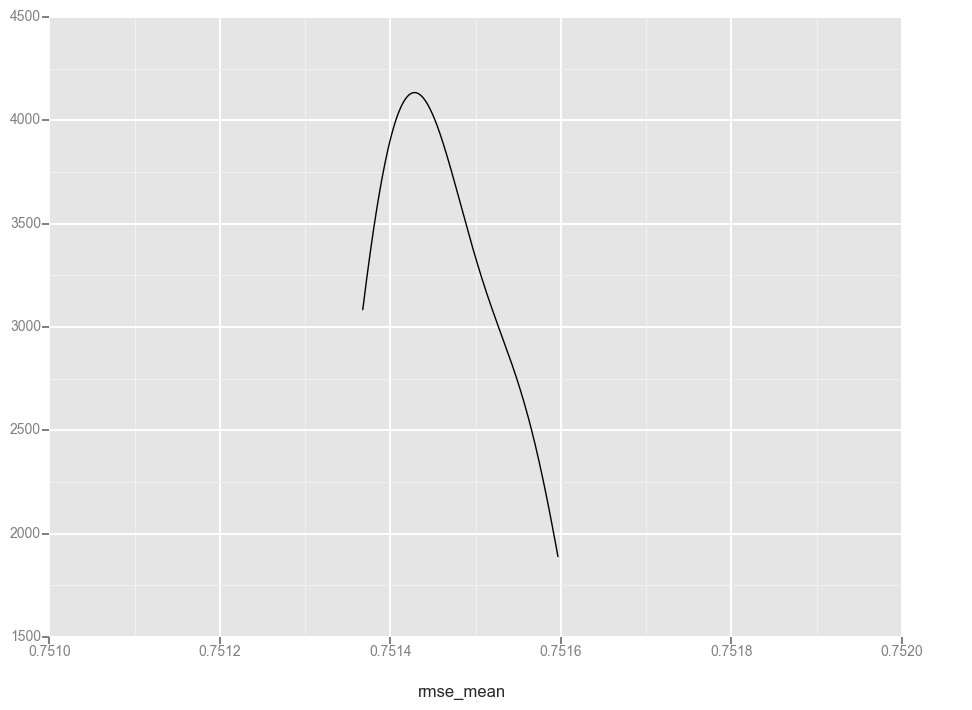

<ggplot: (-9223372036560352750)>

In [293]:
ggplot(best_coefs_df, aes('rmse_mean')) + geom_density() + xlim(0.751, 0.752)

In [260]:
high = best_coefs_df.loc[best_coefs_df.rmse_mean == best_coefs_df.rmse_mean.min()].rmse_mean + \
best_coefs_df.loc[best_coefs_df.rmse_mean == best_coefs_df.rmse_mean.min()].rmse_sd * 1.96 / np.sqrt(10)

low = best_coefs_df.loc[best_coefs_df.rmse_mean == best_coefs_df.rmse_mean.min()].rmse_mean - \
best_coefs_df.loc[best_coefs_df.rmse_mean == best_coefs_df.rmse_mean.min()].rmse_sd * 1.96 / np.sqrt(10)

print ("CI:%.4f-%.4f" % (low, high))

CI:0.7404-0.7624


In [294]:
gbm_coef_grid = [.2]
lasso_coef_grid = [.35, .4, .45]

tmp = X_train_na_fix_full_scaled_.copy()
tmp['response'] = y_train_full.copy()

random_ind = tmp.index.tolist()
np.random.shuffle(random_ind) # random row index

vars_list_ = []

features_ = [name for name in tmp.columns if name != 'response']

cv = 10
j = 1

for gbm_coef_ in gbm_coef_grid:
    for lasso_coef_ in lasso_coef_grid:
        rmse_ = []
        for i, inds in enumerate(np.array_split(random_ind, cv)): # cv - fold CV
    
            clear_output()
            print ("Com.: %d. Lasso coef %.2f, GBM coef %.2f, ridge coef %.2f - fold: %d" % (j, 
                                                                                lasso_coef_, gbm_coef_, 
                                                                                (1 - lasso_coef_ - gbm_coef_), i+1))

            ts = tmp.loc[tmp.index.isin(inds), features_]
            tr = tmp.loc[~tmp.index.isin(inds), features_]
            y_ts = tmp.loc[tmp.index.isin(inds)].response
            y_tr = tmp.loc[~tmp.index.isin(inds)].response
            # lasso
            cv_lasso_fit = LassoCV(max_iter = 20000, alphas = np.arange(.0001, .01, .0001), cv = 50).fit(tr, y_tr)
            lasso_pred = cv_lasso_fit.predict(ts)

            # ridge
            ridge_fit = RidgeCV(alphas = np.arange(1000, 1200, 5), cv = 10).fit(tr, y_tr)
            ridge_pred = ridge_fit.predict(ts)

            # gbm
            gbm_fit = GradientBoostingRegressor(learning_rate = .025, n_estimators = 500, max_depth = 3).fit(tr, y_tr)
            gbm_pred = gbm_fit.predict(ts)


            lasso_pred[lasso_pred > 5] = 5
            ridge_pred[ridge_pred > 5] = 5
            gbm_pred[gbm_pred > 5] = 5
            lasso_pred[lasso_pred < 1] = 1
            ridge_pred[ridge_pred < 1] = 1
            gbm_pred[gbm_pred < 1] = 1
            
            pred_ = lasso_pred * lasso_coef_ + gbm_pred * gbm_coef_ + ridge_pred * (1 - lasso_coef_ - gbm_coef_)
            
            rmse_.append(np.sqrt(mean_squared_error(y_ts, pred_)))
            
        j += 1        
        vars_list_.append({'gbm':gbm_coef_, 'lasso':lasso_coef_, 'ridge':(1-lasso_coef_-gbm_coef_),
                          'rmse_mean':np.mean(rmse_), 'rmse_sd':np.std(rmse_)})

pd.DataFrame(vars_list_)

Com.: 3. Lasso coef 0.45, GBM coef 0.20, ridge coef 0.35 - fold: 10


,gbm,lasso,ridge,rmse_mean,rmse_sd
0,0.2,0.35,0.45,0.751012,0.012847
1,0.2,0.40,0.40,0.750999,0.012839
2,0.2,0.45,0.35,0.750989,0.012838


How about adding PCA + ridge\lasso ?

In [295]:
pca = PCA()
pca.fit(X_train_na_fix_full_scaled_)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [299]:
to_plot_pca = pd.DataFrame({'explained_var':pca.explained_variance_ratio_, 'num':range(pca.n_components_)})

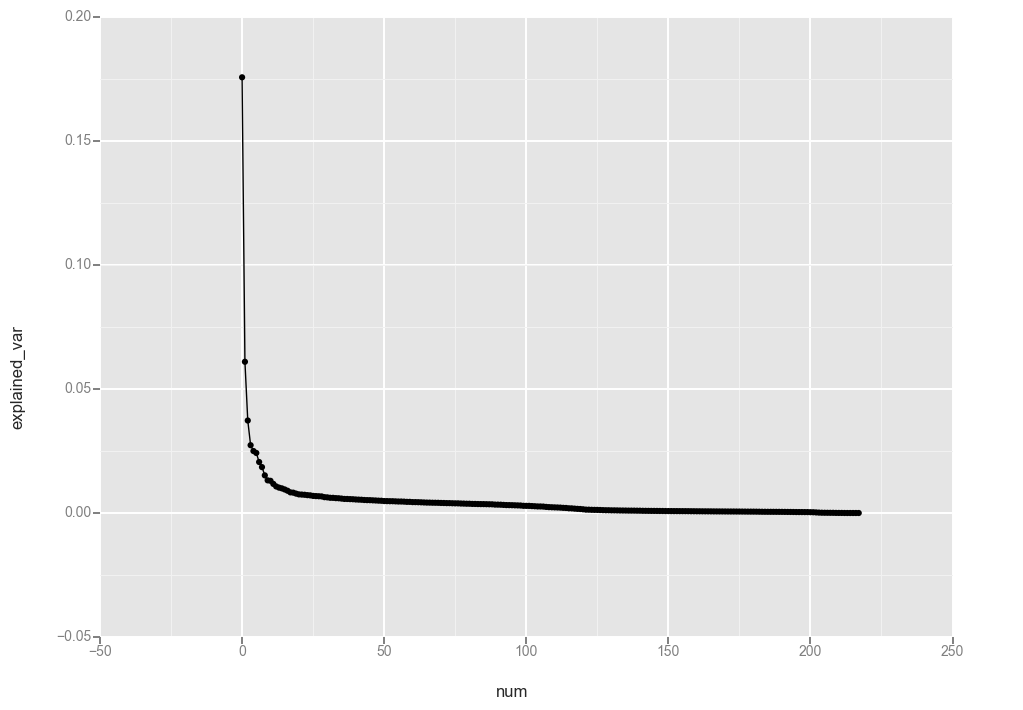

<ggplot: (-9223372036560340308)>

In [300]:
ggplot(to_plot_pca, aes('num', 'explained_var')) + geom_point() + geom_line()

In [318]:
# ggplot(to_plot_pca.loc[to_plot_pca.num < 25], aes('num', 'explained_var')) + geom_point() + geom_line()

Let's take 100 components..

In [316]:
pca = PCA(n_components = 100)
pca_X_train_na_fix_full = pca.fit_transform(X_train_na_fix_full_scaled_)

In [317]:
pca.explained_variance_ratio_.sum()

0.89196877459836366

In [322]:
ridge_mod = RidgeCV(alphas = np.arange(1500, 2000, 10), cv = 20)
ridge_mod.fit(pca_X_train_na_fix_full, y_train_full.values.ravel()).alpha_

1590

In [323]:
ridge_mod = RidgeCV(alphas = np.arange(1500, 1700, 5), cv = 20)
cv = 10
print ("RMSE using %d-fold CV is" % cv, round(np.sqrt(cross_val_score(ridge_mod, 
                                        pca_X_train_na_fix_full, 
                                        y_train_full.values.ravel(),
                                        scoring = "neg_mean_squared_error", 
                                        cv = cv).mean() * -1), 7))

RMSE using 10-fold CV is 0.7566914


Not bad. How about lasso?

In [328]:
lasso_mod = LassoCV(max_iter = 20000, alphas = np.arange(.0001, .01, .0001), cv = 50).fit(pca_X_train_na_fix_full, 
                    y_train_full.values.ravel())
lasso_mod.alpha_

0.0044000000000000003

In [329]:
(lasso_mod.coef_ != 0).sum()

72

In [326]:
lasso_mod = LassoCV(max_iter = 20000, alphas = np.arange(.0001, .01, .0001), cv = 50)
cv = 50

print ("RMSE using %d-fold CV is" % cv, round(np.sqrt(cross_val_score(lasso_mod, 
                                        pca_X_train_na_fix_full, 
                                        y_train_full.values.ravel(), 
                                        scoring = "neg_mean_squared_error", 
                                        cv = cv).mean() * -1), 7))

RMSE using 50-fold CV is 0.7562334


Nice. We will repeat the model where we fit linear reg. to the prediction, now with extra 2 models:
 - PCA + Lasso
 - PCA + Ridge

In [341]:
tmp = X_train_na_fix_full_scaled_.copy()
tmp['response'] = y_train_full.copy()

random_ind = tmp.index.tolist()
np.random.shuffle(random_ind) # random row index

lin_reg_list_w_pca = []

tmp_pca = pd.DataFrame(PCA(n_components = 100).fit_transform(X_train_na_fix_full_scaled_))

cv = 20
features_ = [name for name in tmp.columns if name != 'response']
for i, inds in enumerate(np.array_split(random_ind, cv)): # cv - fold CV
    
    clear_output()
    print (i + 1)
    
    ts_ = tmp.loc[tmp.index.isin(inds), features_]
    tr_ = tmp.loc[~tmp.index.isin(inds), features_]
    y_ts = tmp.loc[tmp.index.isin(inds)].response
    y_tr = tmp.loc[~tmp.index.isin(inds)].response
    
    pca_ts = tmp_pca.loc[tmp_pca.index.isin(inds)]
    pca_tr_ = tmp_pca.loc[~tmp_pca.index.isin(inds)]
    pca_y_ts = y_ts
    pca_y_tr_ = y_tr
    
    # split train into two sets
    tr, va, y_tr, y_va = train_test_split(tr_, y_tr, test_size = .3)
    
    pca_tr = pca_tr_.loc[pca_tr_.index.isin(tr.index)]
    pca_va = pca_tr_.loc[pca_tr_.index.isin(va.index)]
    pca_y_tr = y_tr
    pca_y_va = y_va
    
    # lasso
    cv_lasso_fit = LassoCV(max_iter = 20000, alphas = np.arange(.0001, .01, .0001), cv = 100).fit(tr, y_tr)
    pca_lasso_fit = LassoCV(max_iter = 20000, alphas = np.arange(.0001, .01, .0001), cv = 50).fit(pca_tr, pca_y_tr)
    lasso_pred = cv_lasso_fit.predict(ts)
    lasso_pred_va = cv_lasso_fit.predict(va)
    lasso_pred_pca = pca_lasso_fit.predict(pca_ts)
    lasso_pred_va_pca = pca_lasso_fit.predict(pca_va)
    # ridge
    ridge_fit = RidgeCV(alphas = np.arange(1000, 1200, 5), cv = 10).fit(tr, y_tr)
    ridge_fit_pca = RidgeCV(alphas = np.arange(1500, 1700, 5), cv = 20).fit(pca_tr, pca_y_tr)
    ridge_pred = ridge_fit.predict(ts)
    ridge_pred_va = ridge_fit.predict(va)
    ridge_pred_pca = ridge_fit_pca.predict(pca_ts)
    ridge_pred_va_pca = ridge_fit_pca.predict(pca_va)
    # gbm
    gbm_fit = GradientBoostingRegressor(learning_rate = .025, n_estimators = 500).fit(tr, y_tr)
    gbm_pred = gbm_fit.predict(ts)
    gbm_pred_va = gbm_fit.predict(va)
    
    lasso_pred[lasso_pred > 5] = 5
    lasso_pred_pca[lasso_pred_pca > 5] = 5
    lasso_pred_va_pca[lasso_pred_va_pca > 5] = 5
    ridge_pred[ridge_pred > 5] = 5
    gbm_pred[gbm_pred > 5] = 5
    lasso_pred_va[lasso_pred_va > 5] = 5
    ridge_pred_va[ridge_pred_va > 5] = 5
    ridge_pred_pca[ridge_pred_pca > 5] = 5
    ridge_pred_va_pca[ridge_pred_va_pca > 5] = 5
    gbm_pred_va[gbm_pred_va > 5] = 5
    
    lasso_pred[lasso_pred < 1] = 1
    lasso_pred_pca[lasso_pred_pca < 1] = 1
    lasso_pred_va_pca[lasso_pred_va_pca < 1] = 1
    ridge_pred[ridge_pred < 1] = 1
    gbm_pred[gbm_pred < 1] = 1
    lasso_pred_va[lasso_pred_va < 1] = 1
    ridge_pred_va[ridge_pred_va < 1] = 1
    ridge_pred_pca[ridge_pred_pca < 1] = 1
    ridge_pred_va_pca[ridge_pred_va_pca < 1] = 1
    gbm_pred_va[gbm_pred_va < 1] = 1
    
    preds_ts = pd.DataFrame({'lasso':lasso_pred, 'ridge':ridge_pred, 'gbm':gbm_pred, 'lasso_pca':lasso_pred_pca,
                            'ridge_pca':ridge_pred_pca})
    preds_va = pd.DataFrame({'lasso':lasso_pred_va, 'ridge':ridge_pred_va, 'gbm':gbm_pred_va, 
                             'lasso_pca':lasso_pred_va_pca, 'ridge_pca':ridge_pred_va_pca})
    
    lin_reg_fit = LinearRegression(fit_intercept = False).fit(preds_va, y_va)
    lin_reg_pred = lin_reg_fit.predict(preds_ts)
    
    rf_pred = RandomForestRegressor(n_estimators=100).fit(preds_va, y_va).predict(preds_ts)
    
    lin_reg_list_w_pca.append({preds_va.columns[0]:lin_reg_fit.coef_[0],
                               preds_va.columns[1]:lin_reg_fit.coef_[1],
                               preds_va.columns[2]:lin_reg_fit.coef_[2],
                               preds_va.columns[3]:lin_reg_fit.coef_[3],
                               preds_va.columns[4]:lin_reg_fit.coef_[4],
                               'rmse_lin':np.sqrt(mean_squared_error(y_ts, lin_reg_pred)),
                               'rmse_rf':np.sqrt(mean_squared_error(y_ts, rf_pred))})
    
rmse_lin_reg_w_pca_df = pd.DataFrame(lin_reg_list_w_pca)
rmse_lin_reg_w_pca_df.head()

20


,gbm,lasso,lasso_pca,ridge,ridge_pca,rmse_lin,rmse_rf
0,0.245688,-0.083426,0.387089,0.828978,-0.375510,1.094223,1.124104
1,0.165384,0.668497,-0.087847,0.180071,0.073249,1.159366,1.159996
2,0.377448,0.027242,-0.327777,0.599224,0.321525,1.042416,1.068846
3,0.089892,0.386598,0.093713,0.535011,-0.102619,1.121854,1.135136
4,0.198488,0.179051,-0.065266,0.634572,0.053703,1.110913,1.117659


In [343]:
rmse_lin_reg_w_pca_df['ones'] = 1
rmse_lin_reg_w_pca_df.pivot_table(values=['gbm', 'lasso', 'ridge', 'rmse_lin', 'ridge_pca', 'lasso_pca'], 
                       index = 'ones',
                       aggfunc=[np.mean, np.std]).swaplevel(axis = 1)

,gbm,lasso,lasso_pca,ridge,ridge_pca,rmse_lin,gbm,lasso,lasso_pca,ridge,ridge_pca,rmse_lin
,mean,mean,mean,mean,mean,mean,std,std,std,std,std,std
ones,,,,,,,,,,,,
1,0.183826,0.322361,-0.009819,0.50467,0.000225,1.119309,0.108373,0.31731,0.321058,0.307141,0.319995,0.031484


Looks a bit odd. Maybe there is some problem with the code...

## Prediction

[Top](#Navigation)

### Predictions 1/6

In [418]:
grid_for_lasso = np.arange(.0001, .01, .0001)
grid_for_ridge = np.arange(2065, 2097, .5)

In [407]:
lasso_model = LassoCV(alphas = grid_for_lasso, max_iter = 5000, cv = 20)
lasso_model_fit = lasso_model.fit(X_train_na_fix_full_scaled, y_train_full.values.ravel())

lasso_test_pred = lasso_model_fit.predict(X_test_na_fix_full_scaled)

lasso_test_pred[lasso_test_pred > 5] = 5
lasso_test_pred[lasso_test_pred < 1] = 1

In [408]:
lasso_model.alpha_

0.0055000000000000005

In [409]:
coefs_ = pd.DataFrame({'coef':lasso_model_fit.coef_, 'coef_abs':abs(lasso_model_fit.coef_),
                       'name':X_train_na_fix_full_scaled.columns})
coefs_.sort_values('coef_abs', ascending = False).head(10)

,coef,coef_abs,name
206,0.167214,0.167214,similar_mean
34,0.108143,0.108143,Two Weeks Notice
32,0.085098,0.085098,Sister Act
48,0.072462,0.072462,The Wedding Planner
119,0.053573,0.053573,Two Weeks Notice_is_rate
68,0.050924,0.050924,Erin Brockovich
33,0.046290,0.046290,Double Jeopardy
73,0.041801,0.041801,Tomb Raider
9,0.041675,0.041675,Sweet Home Alabama
208,0.041497,0.041497,similar_number


In [419]:
ridge_model = RidgeCV(alphas = grid_for_ridge, cv = 20)
ridge_model_fit = ridge_model.fit(X_train_na_fix_full_scaled, y_train_full.values.ravel())

ridge_test_pred = ridge_model_fit.predict(X_test_na_fix_full_scaled)

ridge_test_pred[ridge_test_pred > 5] = 5
ridge_test_pred[ridge_test_pred < 1] = 1

In [420]:
ridge_model_fit.alpha_

2075.0

In [421]:
coefs_ridge = pd.DataFrame({'coef':ridge_model_fit.coef_, 'coef_abs':abs(ridge_model_fit.coef_),
                       'name':X_train_na_fix_full_scaled.columns})
coefs_ridge.sort_values('coef_abs', ascending = False).head(10)

,coef,coef_abs,name
34,0.101116,0.101116,Two Weeks Notice
32,0.080526,0.080526,Sister Act
206,0.077342,0.077342,similar_mean
48,0.074102,0.074102,The Wedding Planner
9,0.054787,0.054787,Sweet Home Alabama
119,0.050152,0.050152,Two Weeks Notice_is_rate
68,0.048610,0.048610,Erin Brockovich
33,0.041635,0.041635,Double Jeopardy
117,0.038714,0.038714,Sister Act_is_rate
73,0.038303,0.038303,Tomb Raider


In [423]:
####################
# find best params #
####################
mod_gbm = GradientBoostingRegressor()
params = {'learning_rate':[.05, .025, .01], 'n_estimators':[100,  300, 500, 600], 'max_depth':[2, 3, 4]}

grid_search_gbm = GridSearchCV(mod_gbm, param_grid = params, cv = 5, refit = False)

grid_search_gbm.fit(X_train_na_fix_full_scaled, y_train_full.values.ravel())

grid_search_gbm.best_params_

{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 500}

In [429]:
mod_gbm = GradientBoostingRegressor()
params = {'learning_rate':[.05, .075, .1], 'n_estimators':[500], 'max_depth':[2, 3]}

grid_search_gbm = GridSearchCV(mod_gbm, param_grid = params, cv = 5, refit = False)

grid_search_gbm.fit(X_train_na_fix_full_scaled, y_train_full.values.ravel())

grid_search_gbm.best_params_

{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 500}

In [450]:
cv = 10

cv_results = cross_val_score(
                            GradientBoostingRegressor(learning_rate = .025, n_estimators = 500, max_depth = 3), 
                            scaled_lasso_imp,
                            y_train_full.values.ravel(), 
                            scoring = "neg_mean_squared_error", 
                            cv = cv)

In [451]:
# result for 10-fold cv with {'learning_rate': 0.025, 'max_depth': 3, 'n_estimators': 500}
np.sqrt(cv_results * (-1)).mean()

0.7600828653379248

In [428]:
# result for 10-fold cv with {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 500}
np.sqrt(cv_results * (-1)).mean()

0.76016794936915955

In [452]:
gbm_model = GradientBoostingRegressor(learning_rate = .025, n_estimators = 500, max_depth = 3)
gbm_model_fit = gbm_model.fit(X_train_na_fix_full_scaled, 
                              y_train_full.values.ravel())

gbm_test_pred = gbm_model_fit.predict(X_test_na_fix_full_scaled)

gbm_test_pred[gbm_test_pred > 5] = 5
gbm_test_pred[gbm_test_pred < 1] = 1

In [453]:
coefs_gbm = pd.DataFrame({'coef':gbm_model_fit.feature_importances_,
                           'name':X_train_na_fix_full_scaled.columns
                         })
coefs_gbm.sort_values('coef', ascending = False).head(10)

,coef,name
206,0.088494,similar_mean
34,0.035850,Two Weeks Notice
32,0.028914,Sister Act
207,0.027166,similar_sd
68,0.021907,Erin Brockovich
188,0.021512,sd_of_ratings_per_user
33,0.021437,Double Jeopardy
191,0.018815,days_since_first_rating
73,0.018462,Tomb Raider
217,0.017851,date_year_corr


In [467]:
results_1_6 = pd.DataFrame({'lasso':lasso_test_pred, 'gbm':gbm_test_pred,
                            'ridge':ridge_test_pred})
results_1_6['mean_'] = results_1_6.mean(axis = 1)
results_1_6.head(10)

,gbm,lasso,ridge,mean_
0,4.853561,5.000000,4.982684,4.945415
1,4.916333,5.000000,5.000000,4.972111
2,3.010576,3.010617,3.071608,3.030934
3,3.213871,3.233913,3.207897,3.218560
4,3.168128,3.213640,3.184192,3.188653
5,3.232734,3.078222,3.048341,3.119766
6,4.109194,4.277450,4.138396,4.175013
7,4.283408,4.182585,4.252051,4.239348
8,3.419241,3.390985,3.393102,3.401109
9,2.871905,2.819116,2.825071,2.838698


In [469]:
results_1_6['weighted_mean_'] = (results_1_6['lasso'] + results_1_6['gbm']) * .4 + results_1_6['ridge'] * .2
results_1_6.head(10)

,gbm,lasso,ridge,mean_,weighted_mean_
0,4.853561,5.000000,4.982684,4.945415,4.937961
1,4.916333,5.000000,5.000000,4.972111,4.966533
2,3.010576,3.010617,3.071608,3.030934,3.022799
3,3.213871,3.233913,3.207897,3.218560,3.220693
4,3.168128,3.213640,3.184192,3.188653,3.189546
5,3.232734,3.078222,3.048341,3.119766,3.134050
6,4.109194,4.277450,4.138396,4.175013,4.182337
7,4.283408,4.182585,4.252051,4.239348,4.236807
8,3.419241,3.390985,3.393102,3.401109,3.402711
9,2.871905,2.819116,2.825071,2.838698,2.841423


In [470]:
results_1_6.loc[(results_1_6.lasso - results_1_6.gbm) > .7]

,gbm,lasso,ridge,mean_,weighted_mean_
1053,2.888627,3.621492,3.675316,3.395145,3.339111


In [471]:
results_1_6.loc[(results_1_6.lasso - results_1_6.ridge) > .2]

,gbm,lasso,ridge,mean_,weighted_mean_
142,2.789434,2.772295,2.492887,2.684872,2.723269
392,3.880412,3.780815,3.558169,3.739799,3.776125
821,1.660905,1.485696,1.187442,1.444681,1.496129
1525,3.946827,3.923335,3.686949,3.852370,3.885454
1828,3.986548,3.932184,3.725896,3.881543,3.912672
2711,4.156104,3.981910,3.768366,3.968793,4.008879
2848,2.734985,2.435987,2.215643,2.462205,2.511517


In [472]:
results_1_6.corr()

,gbm,lasso,ridge,mean_,weighted_mean_
gbm,1.000000,0.974150,0.968834,0.987621,0.990253
lasso,0.974150,1.000000,0.995313,0.996737,0.995799
ridge,0.968834,0.995313,1.000000,0.995001,0.992749
mean_,0.987621,0.996737,0.995001,1.000000,0.999791
weighted_mean_,0.990253,0.995799,0.992749,0.999791,1.000000


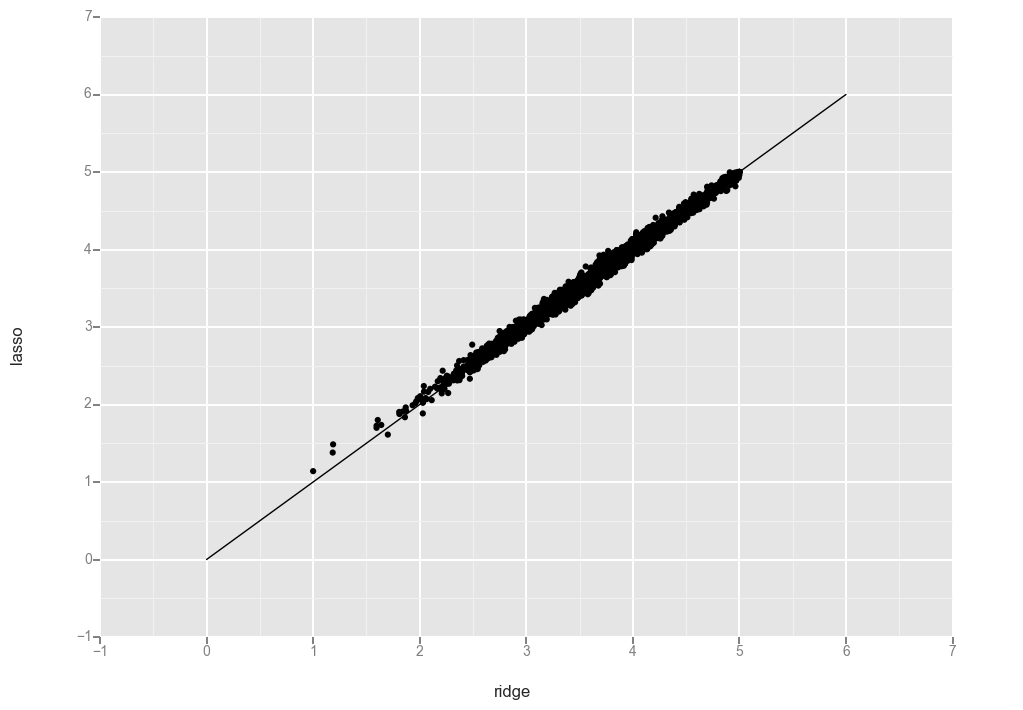

<ggplot: (-9223372036510944014)>

In [473]:
ggplot(results_1_6, aes('ridge', 'lasso')) + geom_point() + geom_abline()

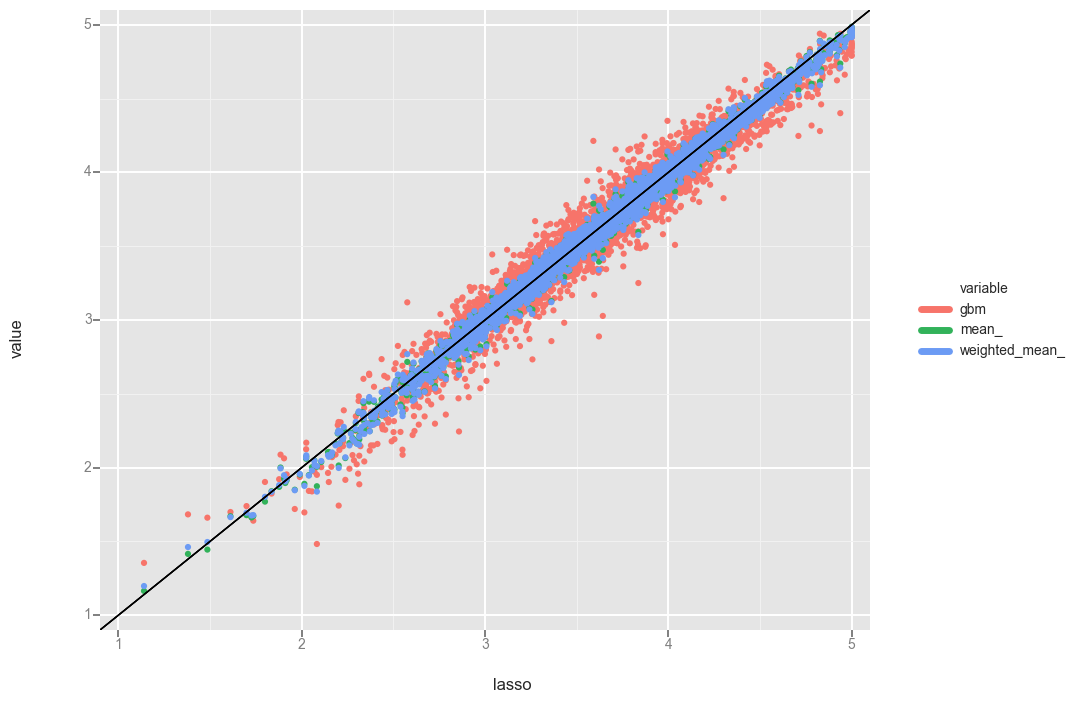

<ggplot: (350824133)>

In [474]:
ggplot(pd.melt(results_1_6[['gbm', 'lasso', 'mean_', 'weighted_mean_']], id_vars = 'lasso'), 
       aes('lasso', 'value', color = 'variable')) +\
    geom_point(alpha = 1) +\
    geom_abline(color = 'black') +\
    xlim(.9, 5.1) +\
    ylim(.9, 5.1)

In [475]:
###### Export
results_1_6[['mean_']].to_csv("Predictions/Prediction_1_6.csv", index = False)

### Predictions 8/6

In [344]:
lasso_alpha_grid = np.arange(.0001, .01, .0001)
ridge_alpha_grid = np.arange(1000, 1200, 5)

In [346]:
lasso_model = LassoCV(alphas = lasso_alpha_grid, max_iter = 5000, cv = 50)
lasso_model_fit = lasso_model.fit(X_train_na_fix_full_scaled_, y_train_full.values.ravel())

lasso_test_pred = lasso_model_fit.predict(X_test_na_fix_full_scaled_)

lasso_test_pred[lasso_test_pred > 5] = 5
lasso_test_pred[lasso_test_pred < 1] = 1

In [347]:
lasso_model_fit.alpha_

0.0030999999999999999

In [348]:
coefs_lasso = pd.DataFrame({'coef':lasso_model_fit.coef_, 'coef_abs':abs(lasso_model_fit.coef_),
                       'name':X_train_na_fix_full_scaled_.columns})
coefs_lasso.sort_values('coef_abs', ascending = False).head(10)

,coef,coef_abs,name
121,0.185319,0.185319,similar_mean
34,0.107397,0.107397,Two Weeks Notice
153,0.104726,0.104726,Two Weeks Notice_is_rate
32,0.078978,0.078978,Sister Act
123,0.072751,0.072751,similar_number
48,0.072653,0.072653,The Wedding Planner
151,0.062474,0.062474,Sister Act_is_rate
204,-0.059893,0.059893,A Few Good Men_is_rate
68,0.054877,0.054877,Erin Brockovich
192,0.047834,0.047834,Tomb Raider_is_rate


In [349]:
ridge_model = RidgeCV(alphas = ridge_alpha_grid, cv = 50)
ridge_model_fit = ridge_model.fit(X_train_na_fix_full_scaled_, y_train_full.values.ravel())

ridge_test_pred = ridge_model_fit.predict(X_test_na_fix_full_scaled_)

ridge_test_pred[ridge_test_pred > 5] = 5
ridge_test_pred[ridge_test_pred < 1] = 1

In [350]:
ridge_model_fit.alpha_

1135

In [351]:
coefs_ridge = pd.DataFrame({'coef':ridge_model_fit.coef_, 'coef_abs':abs(ridge_model_fit.coef_),
                       'name':X_train_na_fix_full_scaled_.columns})
coefs_ridge.sort_values('coef_abs', ascending = False).head(10)

,coef,coef_abs,name
34,0.110269,0.110269,Two Weeks Notice
121,0.086276,0.086276,similar_mean
32,0.085932,0.085932,Sister Act
48,0.081619,0.081619,The Wedding Planner
123,0.079041,0.079041,similar_number
153,0.061040,0.061040,Two Weeks Notice_is_rate
9,0.058147,0.058147,Sweet Home Alabama
68,0.052753,0.052753,Erin Brockovich
33,0.044108,0.044108,Double Jeopardy
73,0.042197,0.042197,Tomb Raider


In [352]:
gbm_model = GradientBoostingRegressor(learning_rate = .025, n_estimators = 500, max_depth = 3)
gbm_model_fit = gbm_model.fit(X_train_na_fix_full_scaled_, 
                              y_train_full.values.ravel())

gbm_test_pred = gbm_model_fit.predict(X_test_na_fix_full_scaled_)

gbm_test_pred[gbm_test_pred > 5] = 5
gbm_test_pred[gbm_test_pred < 1] = 1

In [353]:
coefs_gbm = pd.DataFrame({'coef':gbm_model_fit.feature_importances_,
                           'name':X_train_na_fix_full_scaled_.columns})
coefs_gbm.sort_values('coef', ascending = False).head(10)

,coef,name
121,0.087087,similar_mean
34,0.035842,Two Weeks Notice
32,0.029837,Sister Act
103,0.026953,sd_of_ratings_per_user
122,0.025764,similar_sd
68,0.022272,Erin Brockovich
33,0.022127,Double Jeopardy
73,0.020480,Tomb Raider
106,0.018072,days_since_first_rating
123,0.017032,similar_number


In [354]:
results_8_6 = pd.DataFrame({'lasso':lasso_test_pred, 'gbm':gbm_test_pred,
                            'ridge':ridge_test_pred})
results_8_6.head()

,gbm,lasso,ridge
0,4.887991,5.000000,4.997257
1,4.960855,5.000000,5.000000
2,3.028532,3.045314,3.104896
3,3.202076,3.265297,3.262764
4,3.083817,3.188130,3.179045


In [358]:
results_8_6['new_pred_'] = results_8_6['lasso'] * .45 + results_8_6['ridge'] * .35 + results_8_6['gbm'] * .2
results_8_6.head()

,gbm,lasso,ridge,new_pred_
0,4.887991,5.000000,4.997257,4.976638
1,4.960855,5.000000,5.000000,4.992171
2,3.028532,3.045314,3.104896,3.062811
3,3.202076,3.265297,3.262764,3.251766
4,3.083817,3.188130,3.179045,3.164088


In [ ]:
#### sanity check

In [359]:
prvs_pred = pd.read_csv("Predictions/Prediction_1_6.csv")
to_plot = results_8_6.copy()
to_plot['prvs_pred'] = prvs_pred['mean_']

In [361]:
to_plot[['prvs_pred', 'new_pred_']].corr()

,prvs_pred,new_pred_
prvs_pred,1.000000,0.998216
new_pred_,0.998216,1.000000


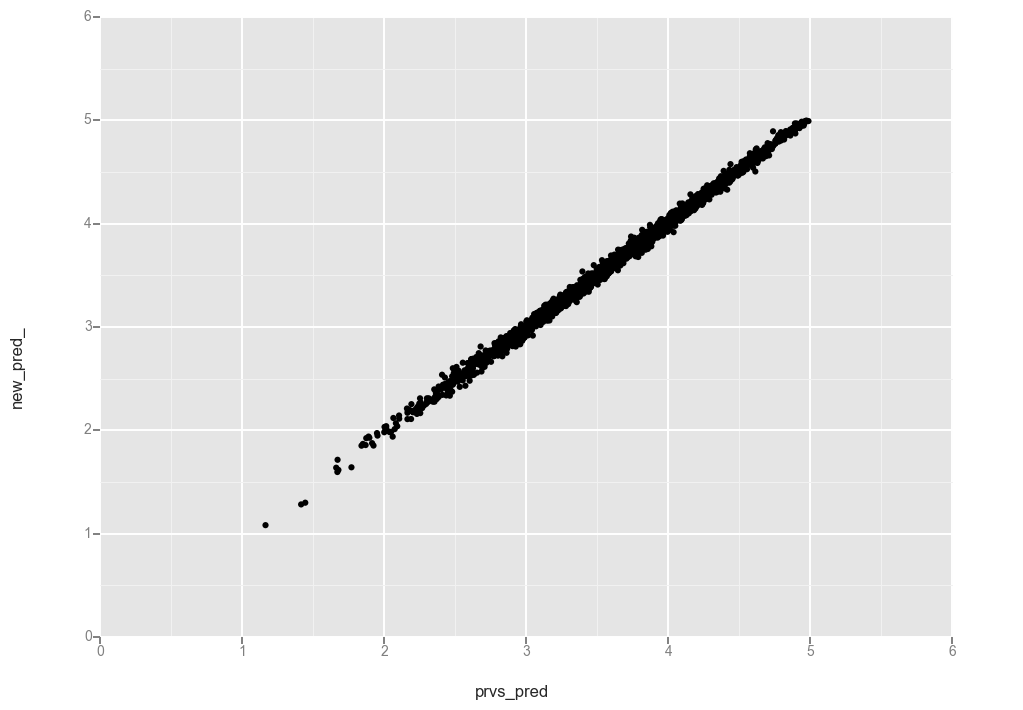

<ggplot: (296045011)>

In [362]:
ggplot(to_plot, aes('prvs_pred', 'new_pred_')) + geom_point()

In [363]:
##########
# Export #
##########
results_8_6.to_csv("Predictions/Prediction_8_6.csv", index = False)

## Data Exploration & Visualisation

[Top](#Navigation)

In [267]:
lasso_m = LassoCV(alphas = np.arange(.0001, .01, .0001), max_iter = 5000, cv = 100)
lasso_m_fit = lasso_m.fit(X_train_na_fix_full_scaled_, y_train_full.values.ravel())
lasso_pred_train = lasso_m_fit.predict(X_train_na_fix_full_scaled_)

In [269]:
to_plot = pd.DataFrame({'pred':lasso_pred_train, 'true':y_train_full.values.ravel()})
to_plot['res_abs'] = abs(to_plot['true'] - to_plot['pred'])
to_plot.head()

,pred,true,res_abs
0,3.749215,4,0.250785
1,2.713733,3,0.286267
2,4.230986,3,1.230986
3,4.458311,5,0.541689
4,3.645062,5,1.354938


In [278]:
to_plot.sort_values('res_abs', ascending = False).head(5)

,pred,true,res_abs
4471,4.695843,1,3.695843
2866,4.091126,1,3.091126
3997,4.080533,1,3.080533
761,2.043222,5,2.956778
3785,3.877250,1,2.877250


In [276]:
u_id = 761
X_train_full[u_id:u_id+1]

,Independence Day,The Patriot,The Day After Tomorrow,Pirates of the Caribbean: The Curse of the Black Pearl,Pretty Woman,Forrest Gump,The Green Mile,Con Air,Twister,Sweet Home Alabama,Pearl Harbor,Armageddon,The Rock,What Women Want,Bruce Almighty,Oceans Eleven,The Bourne Identity,The Italian Job,I Robot,American Beauty,How to Lose a Guy in 10 Days,Lethal Weapon 4,Shrek 2,Lost in Translation,Top Gun,Pulp Fiction,Gone in 60 Seconds,The Sixth Sense,Lord of the Rings: The Two Towers,Men of Honor,Gladiator,Lord of the Rings: The Fellowship of the Ring,Sister Act,Double Jeopardy,Two Weeks Notice,Troy,The Royal Tenenbaums,National Treasure,50 First Dates,Indiana Jones and the Last Crusade,My Big Fat Greek Wedding,Mystic River,Titanic,Dirty Dancing,Catch Me If You Can,Finding Nemo (Widescreen),The Matrix,Kill Bill: Vol. 1,The Wedding Planner,The Shawshank Redemption Special Edition,The Last Samurai,John Q,Swordfish,The Bourne Supremacy,The Terminal,Men in Black II,Spider-Man 2,Braveheart,Men in Black,Ghost,Air Force One,Lord of the Rings: The Return of the King,Man on Fire,The Incredibles,Mr Deeds,Collateral,Spider-Man,Saving Private Ryan,Erin Brockovich,Monsters Inc.,Shrek (Full-screen),The Silence of the Lambs,Memento,Tomb Raider,Ferris Buellers Day Off,Maid in Manhattan,Entrapment,Meet the Parents,Dodgeball A True Underdog Story,Rain Man,Patch Adams,Big Fish,Fight Club,S.W.A.T.,Good Will Hunting,A Few Good Men,Enemy of the State,The Generals Daughter,Minority Report,Somethings Gotta Give,Raiders of the Lost Ark,Anger Management,Sideways,Kill Bill: Vol. 2,American Pie,The Fast and the Furious,The School of Rock,Napoleon Dynamite,The Notebook,Bruce Almighty_is_rate,Oceans Eleven_is_rate,The Bourne Identity_is_rate,The Italian Job_is_rate,I Robot_is_rate,American Beauty_is_rate,How to Lose a Guy in 10 Days_is_rate,Lethal Weapon 4_is_rate,Shrek 2_is_rate,Lost in Translation_is_rate,Top Gun_is_rate,Pulp Fiction_is_rate,Gone in 60 Seconds_is_rate,The Sixth Sense_is_rate,Lord of the Rings: The Two Towers_is_rate,Men of Honor_is_rate,Gladiator_is_rate,Lord of the Rings: The Fellowship of the Ring_is_rate,Sister Act_is_rate,Double Jeopardy_is_rate,Two Weeks Notice_is_rate,Troy_is_rate,The Royal Tenenbaums_is_rate,National Treasure_is_rate,50 First Dates_is_rate,Indiana Jones and the Last Crusade_is_rate,My Big Fat Greek Wedding_is_rate,Mystic River_is_rate,Titanic_is_rate,Dirty Dancing_is_rate,Catch Me If You Can_is_rate,Finding Nemo (Widescreen)_is_rate,The Matrix_is_rate,Kill Bill: Vol. 1_is_rate,The Wedding Planner_is_rate,The Shawshank Redemption Special Edition_is_rate,The Last Samurai_is_rate,John Q_is_rate,Swordfish_is_rate,The Bourne Supremacy_is_rate,The Terminal_is_rate,Men in Black II_is_rate,Spider-Man 2_is_rate,Braveheart_is_rate,Men in Black_is_rate,Ghost_is_rate,Air Force One_is_rate,Lord of the Rings: The Return of the King_is_rate,Man on Fire_is_rate,The Incredibles_is_rate,Mr Deeds_is_rate,Collateral_is_rate,Spider-Man_is_rate,Saving Private Ryan_is_rate,Erin Brockovich_is_rate,Monsters Inc._is_rate,Shrek (Full-screen)_is_rate,The Silence of the Lambs_is_rate,Memento_is_rate,Tomb Raider_is_rate,Ferris Buellers Day Off_is_rate,Maid in Manhattan_is_rate,Entrapment_is_rate,Meet the Parents_is_rate,Dodgeball A True Underdog Story_is_rate,Rain Man_is_rate,Patch Adams_is_rate,Big Fish_is_rate,Fight Club_is_rate,S.W.A.T._is_rate,Good Will Hunting_is_rate,A Few Good Men_is_rate,Enemy of the State_is_rate,The Generals Daughter_is_rate,Minority Report_is_rate,Somethings Gotta Give_is_rate,Raiders of the Lost Ark_is_rate,Anger Management_is_rate,Sideways_is_rate,Kill Bill: Vol. 2_is_rate,American Pie_is_rate,The Fast and the Furious_is_rate,The School of Rock_is_rate,Napoleon Dynamite_is_rate,The Notebook_is_rate,y_dates,number_of_ratings_per_user,avg_of_ratings_per_user,median_of_ratings_per_user,sd_of_ratings_per_user,min_ratings_per_user,max_ratings_per_user,days_since_first_rating,prop_1,prop_2,prop_3,prop_4,prop_5,num_same_date

## Play Ground

[Top](#Navigation)

In [239]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(50, input_dim = 218, activation='relu')) #, init = 'normal' , input_dim=218
    model.add(Dense(15, activation='relu')) #, init = 'normal'
    model.add(Dense(1, activation='relu'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [240]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=5, verbose=0)

In [241]:
X_train_na_fix_full_scaled.shape

(10000, 218)

In [242]:
start = time.time()
kfold = KFold(n_splits=5, random_state=seed)
results = cross_val_score(estimator, 
                          X_train_na_fix_full_scaled.as_matrix(), 
                          y_train_full.values.ravel(), 
                          cv=kfold,
                          scoring = "neg_mean_squared_error")
end = time.time()
print("Results: %.2f (%.2f) RMSE" % (results.mean() * (-1), results.std()))
print ((end - start) / 60)

Results: 1.12 (0.06) RMSE
24.94067189693451


In [243]:
results

array([-1.03366595, -1.11905353, -1.19988074, -1.15633045, -1.07838762])

## ToDo

- boltzmann tree ?
- use lin. reg. in order to find coefs for the predictions (GBM, Lasso, ...)
- don't scale xxx_is_rate vars ?

[Top](#Navigation)